# Análisis de sentimiento



El dataset utilizado en esta práctica recopila reseñas de hoteles andaluces en TripAdvisor. Ha sido construido basándose en el corpus COAH (Corpus of Opinions about Andalusian Hotels) y complementado por Mariia Chizhikova. El dataset se encuentra publicado para su uso en [Kaggle](https://www.kaggle.com/datasets/chizhikchi/andalusian-hotels-reviews-unbalanced/data).

Además se aloja una copia en el siguiente [enlace](https://drive.google.com/file/d/1AdUzkAd8UoUgTYa5SQbZZvzLKTX0vzjH/view?usp=drive_link) para la realización de esta práctica. Descargamos el archivo y lo subimos a nuestro entorno de trabajo.

Una vez hecho esto podemos leer el archivo:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
info_hoteles = pd.read_csv("hoteles.csv")
info_hoteles.head()

,index,title,rating,review_text,location,hotel,label
0,0,IMPOSIBLE DESCANSAR,2,El fin de semana mi pareja y yo hicimos una re...,Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,0
1,1,No es oro todo lo que reluce,3,"El hotel en general está bien, las habtiacione...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,3
2,2,Un buen hotel con mucho ruido.,3,"El hotel es moderno, amplio y limpio, pero no ...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,3
3,3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,2,Calefacción averiada o no operativa. Se coment...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,0
4,4,Deja bastante que desear.,2,Este hotel ha bajado notoriamente su categoria...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,0


In [3]:
info_hoteles.shape

(7615, 7)

### Exploración del conjunto de datos

Observamos que las partes más interesante de la tabla son las columnas:

- `title` en la que se titula la reseña con una frase
- `review_text` donde tenemos el texto de la reseña
- `label` con la etiqueta de la reseña siendo 0 cuando es negativa, 1 cuando es neutra y 3 cuando es positiva.

En este caso vamos a descartar las opiniones neutrales:

In [4]:
info_hoteles_sin_neutrales = info_hoteles[info_hoteles.label!=1]

<Axes: title={'center': 'label'}, ylabel='Frequency'>

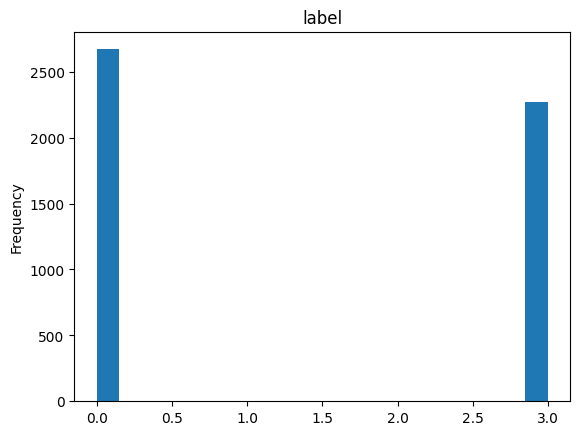

In [5]:
from matplotlib import pyplot as plt
info_hoteles_sin_neutrales['label'].plot(kind='hist', bins=20, title='label')


Vamos a probar si los títulos son suficientes para poder analizar el sentimiento. Empecemos por el preprocesamiento:

In [6]:
titulos_sentimiento = info_hoteles_sin_neutrales[["title", "label"]]

In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize #tokenizador
from nltk.corpus import stopwords #palabras vacías
from nltk.stem import SnowballStemmer #herramienta de stemming

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def preproceso(texto):
  # Preprocesamos el texto
  palabras = word_tokenize(texto) #tokenizo el texto
  palabras = [palabra.lower() for palabra in palabras] #paso las palabras a minúsculas
  palabras = [palabra for palabra in palabras if palabra.isalpha()] #descarto caracteres no alfabéticos
  palabras_vacias = set(stopwords.words('spanish')) #cargo las palabras vacías del español
  palabras = [palabra for palabra in palabras if palabra not in palabras_vacias] #elimino palabras vacías

  return palabras


Preproceso los títulos:

In [10]:
titulos_sentimiento["titulo_preprocesado"] = titulos_sentimiento["title"].apply(lambda texto: preproceso(texto))
titulos_sentimiento.head()

,title,label,titulo_preprocesado
0,IMPOSIBLE DESCANSAR,0,"[imposible, descansar]"
1,No es oro todo lo que reluce,3,"[oro, reluce]"
2,Un buen hotel con mucho ruido.,3,"[buen, hotel, ruido]"
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,0,"[calefacción, operativa, frío]"
4,Deja bastante que desear.,0,"[deja, bastante, desear]"


## Fin carga de datos y preprocesamiento

## Inicio Análisis de Sentimiento

## Primera aproximación

Creamos una función que puntua los títulos según las palabras que aparecen en los mismos. Es una función muy básica que apenas tiene inteligencia pero es una primera aproximación:

In [11]:
def evalua_titulo(titulo_preprocesado, lista_palabras_positivas, lista_palabras_negativas):
  resultado = 0
  for palabra in titulo_preprocesado:
    if palabra in lista_palabras_negativas:
      resultado = resultado - 1
    if palabra in lista_palabras_positivas:
      resultado = resultado + 1
  return resultado

Defino las listas de palabras:

In [12]:
palabras_positivas = ["bueno", "genial", "estupendo", "buen", "bien", "fantástico", "lujo", "agradable", "contento", "excelente", "bonito", "aceptable"]
palabras_negativas = ["malo", "flojo", "fatal", "terrible", "horrible", "feo", "lejos", "ruido", "infame"]

In [13]:
titulos_sentimiento["prediccion_basica"] = titulos_sentimiento["titulo_preprocesado"].apply(lambda texto: evalua_titulo(texto, palabras_positivas, palabras_negativas))


In [14]:
titulos_sentimiento.head()

,title,label,titulo_preprocesado,prediccion_basica
0,IMPOSIBLE DESCANSAR,0,"[imposible, descansar]",0
1,No es oro todo lo que reluce,3,"[oro, reluce]",0
2,Un buen hotel con mucho ruido.,3,"[buen, hotel, ruido]",0
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,0,"[calefacción, operativa, frío]",0
4,Deja bastante que desear.,0,"[deja, bastante, desear]",0


Vemos cómo la aproximación es demasiado básica y salen muchas opciones a 0 porque no detecta ninguna palabra. Ojeando podemos ver cómor refinar el método añadiendo nuevas palabras.

Veámos los casos en los que ha acertado:

In [15]:
titulos_sentimiento[titulos_sentimiento.prediccion_basica!=0].shape[0]

724

In [16]:
titulos_sentimiento[titulos_sentimiento.prediccion_basica!=0].shape[0]/titulos_sentimiento.shape[0]

0.14641051567239635

En 724 casos hemos emitido una predicción. Veámos unas cuantas:

In [17]:
titulos_sentimiento[titulos_sentimiento.prediccion_basica!=0]

,title,label,titulo_preprocesado,prediccion_basica
15,Ruido insoportable de discoteca,0,"[ruido, insoportable, discoteca]",-1
29,Medio aceptable,3,"[medio, aceptable]",1
35,Una pena. No vale las 4 estrellas. Necesita re...,3,"[pena, vale, estrellas, necesita, reforma, mej...",1
37,Perfecto para ir de paso y bien ubicado.,3,"[perfecto, ir, paso, bien, ubicado]",1
38,Bueno,3,[bueno],1
...,...,...,...,...
4930,Muy bien situado,3,"[bien, situado]",1
4933,horrible lugar,0,"[horrible, lugar]",-1
4942,infame,0,[infame],-1
4943,aceptable,3,[aceptable],1


Aunque tenemos pocas predicciones parecen bastante acertadas. Vamos a ver hasta qué punto hemos aceptado:

In [18]:
def ajusta_prediccion(prediccion):
  if prediccion < 0:
    return 0
  elif prediccion > 0:
    return 3
  else:
    return 2

In [21]:
titulos_sentimiento["prediccion_ajustada"] = titulos_sentimiento["prediccion_basica"].apply(lambda prediccion: ajusta_prediccion(prediccion))
titulos_sentimiento[titulos_sentimiento.prediccion_basica!=0].head(15)

,title,label,titulo_preprocesado,prediccion_basica,prediccion_ajustada
15,Ruido insoportable de discoteca,0,"[ruido, insoportable, discoteca]",-1,0
29,Medio aceptable,3,"[medio, aceptable]",1,3
35,Una pena. No vale las 4 estrellas. Necesita re...,3,"[pena, vale, estrellas, necesita, reforma, mej...",1,3
37,Perfecto para ir de paso y bien ubicado.,3,"[perfecto, ir, paso, bien, ubicado]",1,3
38,Bueno,3,[bueno],1,3
42,Bonito Hotel pero alejado,3,"[bonito, hotel, alejado]",1,3
46,"por su excelente situación, muy cómoda para ir...",3,"[excelente, situación, cómoda, ir, venir]",1,3
52,Personal excelente pero no es un 4 estrellas,3,"[personal, excelente, estrellas]",1,3
68,Buen sitio,3,"[buen, sitio]",1,3
70,"Hotel excelente, comida regular.",3,"[hotel, excelente, comida, regular]",1,3


Calculamos las métricas de acierto. Empezamos por ver en cuántos de los casos en los que hemos emitido una predicción hemos acertado:

In [22]:
predicciones_emitidas = titulos_sentimiento[titulos_sentimiento["prediccion_basica"]!=0]
predicciones_emitidas.shape[0]

724

In [23]:
predicciones_acertadas = predicciones_emitidas[predicciones_emitidas["label"]==predicciones_emitidas["prediccion_ajustada"]]

In [24]:
predicciones_acertadas.shape[0]

627

Sobre el total de predicciones emitadas hemos logrado un acierto del 87%. ¡Nada mal para una aproximación tan básicas!

Además podemos evaluar cómo han sido los errores en las 97 predicciones falladas:

In [25]:
predicciones_falladas = predicciones_emitidas[predicciones_emitidas["label"]!=predicciones_emitidas["prediccion_ajustada"]]

In [26]:
predicciones_optimistas = predicciones_falladas[predicciones_falladas["prediccion_ajustada"]==3]

In [27]:
predicciones_optimistas.head()

,title,label,titulo_preprocesado,prediccion_basica,prediccion_ajustada
74,Hotel muy bueno,0,"[hotel, bueno]",1,3
113,"Hotel nuevo, en sitio bueno pero con pegas…",0,"[hotel, nuevo, sitio, bueno]",1,3
160,Nada contento,0,[contento],1,3
209,"Tres estrellas justitas, más bien dos",0,"[tres, estrellas, justitas, bien, dos]",1,3
277,El aire acondicionado es un lujo en este hotel,0,"[aire, acondicionado, lujo, hotel]",1,3


In [28]:
predicciones_optimistas.shape[0]

64

In [29]:
predicciones_pesimistas = predicciones_falladas[predicciones_falladas["prediccion_ajustada"]==0]

In [30]:
predicciones_pesimistas.head()

,title,label,titulo_preprocesado,prediccion_basica,prediccion_ajustada
180,Mucho ruido,3,[ruido],-1,0
234,Habitación buena pero mucho ruido,3,"[habitación, buena, ruido]",-1,0
448,Hotel regular tirando a malo,3,"[hotel, regular, tirando, malo]",-1,0
603,"Buena ubicación y con encanto, pero cuidado co...",3,"[buena, ubicación, encanto, cuidado, ruido]",-1,0
917,Lejos de todo. Personal muy amable,3,"[lejos, personal, amable]",-1,0


In [31]:
predicciones_pesimistas.shape[0]

33

### Conclusión aproximación básica

Como podemos ver nos quedamos muy lejos de un uso funcional aunque puede resultar útil para una exploración concienzuda. Es un método que puede mejorarse de manera iterativa y que puede constituir un buen modelo base con el que empezar.

## Modelo de IA para análisis de sentimiento

In [32]:
! pip install sentiment-analysis-spanish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.0/30.0 MB 16.9 MB/s eta 0:00:00


In [33]:
from sentiment_analysis_spanish import sentiment_analysis
model_sentiment = sentiment_analysis.SentimentAnalysisSpanish()

In [34]:
def sentimiento(texto, sentiment=model_sentiment):
  return sentiment.sentiment(texto)

In [35]:
sentimiento("eso es genial")

0.8360007904858758

In [36]:
sentimiento("eso es horrible")

0.0010557031145171283

In [37]:
titulos_sentimiento["prediccion_ia"] = titulos_sentimiento["title"].apply(lambda texto: sentimiento(texto))

In [38]:
titulos_sentimiento.head()

,title,label,titulo_preprocesado,prediccion_basica,prediccion_ajustada,prediccion_ia
0,IMPOSIBLE DESCANSAR,0,"[imposible, descansar]",0,2,0.292681
1,No es oro todo lo que reluce,3,"[oro, reluce]",0,2,0.116194
2,Un buen hotel con mucho ruido.,3,"[buen, hotel, ruido]",0,2,0.999661
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,0,"[calefacción, operativa, frío]",0,2,0.068262
4,Deja bastante que desear.,0,"[deja, bastante, desear]",0,2,0.000254


De nuevo ajusto las predicciones:

In [39]:
def ajusto_predicciones_ia(prediccion):
  if prediccion < 0.5:
    return 0
  else:
    return 3

In [40]:
titulos_sentimiento["prediccion_ia_ajustada"] = titulos_sentimiento["prediccion_ia"].apply(lambda prediccion: ajusto_predicciones_ia(prediccion))

In [41]:
predicciones_acertadas_ia = titulos_sentimiento[titulos_sentimiento["label"]==titulos_sentimiento["prediccion_ia_ajustada"]]

In [42]:
predicciones_acertadas_ia.shape[0]

3417

In [43]:
predicciones_acertadas_ia.shape[0]/titulos_sentimiento.shape[0]

0.6910010111223458

¡Tenemos un acierto de entorno al 70%! Nada mal.

Os animo a completar las celdas restantes para ver si esta clasificación es optimista o pesimista.

#### Conclusión

Hemos explorado dos maneras de realizar el análisis de sentimientos, un uso muy popular del PLN. En todo este campo siempre existen distintas aproximaciones según el tiempo del que dispongamos y de los recursos que podamos usar. Os animos a explorar estos modelos introduciendo vuestras propias reseñas y viendo sus resultados. ¡Muchas gracias!